### Los Engranajes de las Redes Neuronales: Operaciones con Tensores

**Nota:** No vamos a usar notación matemática algebráica de Tensores, dado que no es el objetivo de esta sección. Necesitamos su conocimiento conceptual y práctico

Cuando al princípio creabamos la RNA con la definición de una capa con el código:

```
keras.layer.Dense(512, activation='relu')
```

Esa capa se puede interpretar como una función:

``output = relu(dot(W, input) + b)``

Que toma un tensor 2D (``W``) al que le aplicamos el **producto escalar**  ``dot`` contra el tensor de entrada (``input``), que a su vez devuelve un tensor 2D que lo sumamos con un **vector** ``b`` y devuelve de nuevo un tensor 2D al que aplicamos la función ``relu.relu(x)`` que es max(x,0) lo cual devuelve un tensor 2D al ``output``

#### Operaciones elemento a elemento
- Suma y relu son elemento a elemento: Operaciones que se aplican de manera independiente a cada entrada de los tensores.
- Permiten implementaciones paralelas masivas

In [1]:
def naive_relu(x):
    assert len(x.shape) == 2 # x es un tensor 2D Numpy
    x = x.copy() # Evita sobreescribir el tensor de entrada
    for i in range(x.shape[0]):
        for j in range(x.shape[1]):
            x[i, j] = max(x[i, j], 0)
    return x

import numpy as np

x = np.array([[5, -78, 2, -34, 0],
              [6, -79, 3, -35, 1],
              [7, -80, 4, -36, 2]])


x.shape, x.shape[0], x.shape[1], naive_relu(x)

((3, 5),
 3,
 5,
 array([[5, 0, 2, 0, 0],
        [6, 0, 3, 0, 1],
        [7, 0, 4, 0, 2]]))

In [2]:
# Solo soporta suma de tensores 2D con formas idénticas
def naive_add(x, y):
    assert len(x.shape) == 2 # x e y son tensores 2D Nimpy
    assert x.shape == y.shape
    x = x.copy() # Evita sobreescribir el tensor de entrada
    for i in range(x.shape[0]):
        for j in range(x.shape[1]):
            x[i, j] += y[i, j]
    return x

x = np.array([[5, 78, 2, 34, 0],
              [6, 79, 3, 35, 1],
              [7, 80, 4, 36, 2]])

y = np.array([[5, 78, 2, 34, 0],
              [6, 79, 3, 35, 1],
              [7, 80, 4, 36, 2]])

naive_add(x, y)

array([[ 10, 156,   4,  68,   0],
       [ 12, 158,   6,  70,   2],
       [ 14, 160,   8,  72,   4]])

Siguiendo el mismo proncípio, se pueden hacer, multiplicaciones, restas, etc, elemento a elemento. En la práctica, para el caso de matrices Numpy, estas operaciones ya están integradas y optimizadas en las **BLAS** (Basic Linear Algebra Subprograms) que están implementadas en Fortran o C.

In [3]:
import time

x = np.random.random((20, 100))
y = np.random.random((20, 100))

t0 = time.time()
for _ in range(1000):
    z = x + y # Suma elemento a elemento
    z = np.maximum(z, 0.) # relu elemento a elemento
print("Took: {0:.2f} s".format(time.time() - t0))

Took: 0.01 s


Que es bastante más eficiente que:

In [4]:
t0 = time.time()
for _ in range(1000):
    z = naive_add(x, y)
    z = naive_relu(z)
print("Took: {0:.2f} s".format(time.time() - t0))

Took: 2.27 s


#### Broadcasting
- El `naive_add` implementado antes solo soporta suma de tensores 2D con formas idénticas y en ``output = relu(dot(W, input) + b)`` sumamos un tensor 2D con un vector: Si no hay "ambigüedad" el tensor más pequeño se **expandirá** para coincidir con la forma del más grande. Esto es conocido como **broadcasting** y tiene 2 pasos:
  1. Se añaden **ejes broadcast** al tensor más pequeño para que coincida con el `ndim` del tensor más grande
  2. El tensor pequeño se **repite a lo largo de los nuevos ejes** para coincidir con la forma completa del tensor grande

In [5]:
import numpy as np
# x tiene la forma (32,10)
x = np.random.random((32, 10))
# y tiene la forma (10,)
y = np.random.random((10,))
x, y

(array([[0.99875497, 0.83746254, 0.13920408, 0.1296908 , 0.56791026,
         0.91551584, 0.54068708, 0.5742409 , 0.84707451, 0.55759025],
        [0.32753222, 0.02160917, 0.41190653, 0.73547811, 0.32537684,
         0.93145538, 0.1890303 , 0.21320147, 0.61027403, 0.98371652],
        [0.95729567, 0.98622716, 0.75430746, 0.81611397, 0.57704593,
         0.3091423 , 0.98700089, 0.62952151, 0.32454127, 0.95318092],
        [0.88377367, 0.34257779, 0.57000017, 0.14725752, 0.56768335,
         0.15196237, 0.15918039, 0.43189923, 0.25802163, 0.33916168],
        [0.74473185, 0.7570977 , 0.6259271 , 0.12303727, 0.43620457,
         0.21425799, 0.16159293, 0.00299034, 0.74885597, 0.19911205],
        [0.81172814, 0.31720009, 0.33728204, 0.16195665, 0.91437406,
         0.01954215, 0.7440907 , 0.74140475, 0.68969961, 0.13498669],
        [0.60031123, 0.70271673, 0.96388312, 0.42936953, 0.33642498,
         0.86719776, 0.16780753, 0.58443004, 0.06013675, 0.38681513],
        [0.956269  , 0.2575

In [6]:
# Añadimos un eje vacío a y
y = np.expand_dims(y, axis=0)
y.shape

(1, 10)

In [7]:
# Repetimos y 32 vaces a lo largo de este nuevo eje. Así que acabamos
# con un tensor Y con la forma (32, 10), donde Y[i, :]==i en range(0, 32)
Y = np.concatenate([y] * 32, axis=0)
Y.shape

(32, 10)

In [8]:
Y

array([[0.68007175, 0.4845292 , 0.5107839 , 0.16389979, 0.56258099,
        0.48805223, 0.12489901, 0.26349036, 0.17221273, 0.84972947],
       [0.68007175, 0.4845292 , 0.5107839 , 0.16389979, 0.56258099,
        0.48805223, 0.12489901, 0.26349036, 0.17221273, 0.84972947],
       [0.68007175, 0.4845292 , 0.5107839 , 0.16389979, 0.56258099,
        0.48805223, 0.12489901, 0.26349036, 0.17221273, 0.84972947],
       [0.68007175, 0.4845292 , 0.5107839 , 0.16389979, 0.56258099,
        0.48805223, 0.12489901, 0.26349036, 0.17221273, 0.84972947],
       [0.68007175, 0.4845292 , 0.5107839 , 0.16389979, 0.56258099,
        0.48805223, 0.12489901, 0.26349036, 0.17221273, 0.84972947],
       [0.68007175, 0.4845292 , 0.5107839 , 0.16389979, 0.56258099,
        0.48805223, 0.12489901, 0.26349036, 0.17221273, 0.84972947],
       [0.68007175, 0.4845292 , 0.5107839 , 0.16389979, 0.56258099,
        0.48805223, 0.12489901, 0.26349036, 0.17221273, 0.84972947],
       [0.68007175, 0.4845292 , 0.5107839

In [9]:
Y[0]

array([0.68007175, 0.4845292 , 0.5107839 , 0.16389979, 0.56258099,
       0.48805223, 0.12489901, 0.26349036, 0.17221273, 0.84972947])

In [10]:
def naive_add_matrix_and_vector(x, y):
    assert len(x.shape) == 2
    assert len(y.shape) == 1
    assert x.shape[1] == y.shape[0]
    x = x.copy()
    for i in range(x.shape[0]):
        for j in range(x.shape[1]):
            x[i, j] += y[j]
    return x

# x tiene la forma (32,10)
x = np.random.random((32, 10))
# y tiene la forma (10,)
y = np.random.random((10,))
x, y, naive_add_matrix_and_vector(x, y)

(array([[6.06066292e-01, 4.28387473e-01, 2.32392308e-01, 2.18522418e-01,
         3.68218790e-01, 1.34665255e-01, 9.28455229e-01, 1.51362387e-01,
         1.02100019e-01, 9.65601889e-01],
        [8.03170073e-01, 7.30164376e-01, 7.15547271e-01, 5.83571940e-01,
         6.20249923e-01, 7.32396176e-01, 6.19495995e-01, 6.64515212e-01,
         5.67549580e-01, 7.72882242e-03],
        [6.80031366e-01, 4.15191914e-01, 7.47474651e-02, 8.19238766e-01,
         2.67853088e-02, 3.59451921e-01, 7.66483483e-01, 1.55941995e-01,
         5.40895447e-01, 9.01764464e-02],
        [8.12368592e-01, 4.79608596e-01, 5.57889146e-01, 4.76331513e-01,
         7.02564171e-02, 9.15988768e-01, 7.98963017e-02, 2.43475525e-01,
         5.07620053e-01, 9.41183477e-01],
        [5.64358038e-01, 4.62622758e-01, 3.08105428e-01, 1.58158283e-01,
         1.84784510e-01, 9.55712096e-01, 3.44809117e-01, 6.93684762e-01,
         5.77913598e-01, 6.74413958e-01],
        [6.24114122e-01, 8.79746750e-01, 7.75922199e-01, 5.0

Broadcasting se puede aplicar a dos tensores si uno tiene la forma `(a, b, ... n, n+1, ... m)` y el otro `(n, n+1, ... m)`. El broadcasting se producirá automáticamente para los ejes `a` hasta `n-1`

In [11]:
# Ejemplo aplicación operación maximun elemento a elemento a dos tensores
# de distinta forma mediante broadcasting
import numpy as np
x = np.random.random((64, 3, 32, 10))
y = np.random.random((32, 10))
# El resultado z tendrá forma (64, 3, 32, 10), como x
z = np.maximum(x, y)
z.shape

(64, 3, 32, 10)

#### Producto Tensorial
- Producto Tensorial `dot` (en Numpy y Keras, sintaxis diferente en TensorFlow) **no** es un producto elemento a elemento (que también existe y lo hemos visto antes). Es la operación de tensores más útil y habitual.
- Producto elemento a elemento se hace con `*` en Numpy, Keras, Theano y TensorFlow

In [12]:
import numpy as np
x = np.random.random((32,))
y = np.random.random((32,))
z = np.dot(x, y)
x, y, z

(array([0.33003469, 0.60662258, 0.49474609, 0.22732064, 0.66434893,
        0.71184569, 0.3681768 , 0.04903488, 0.39373847, 0.29360836,
        0.78501933, 0.71090882, 0.57386286, 0.60531659, 0.940019  ,
        0.00787523, 0.93645246, 0.33941628, 0.92686162, 0.13646488,
        0.7267216 , 0.40723271, 0.9029873 , 0.7509624 , 0.78999662,
        0.96362052, 0.400922  , 0.54373171, 0.20502332, 0.24368891,
        0.11615936, 0.64210582]),
 array([0.48547305, 0.85039335, 0.98364135, 0.09956578, 0.98380869,
        0.84109788, 0.98134729, 0.12621774, 0.24226422, 0.23664969,
        0.33858753, 0.39359731, 0.81361648, 0.27246131, 0.5099396 ,
        0.27269488, 0.14991446, 0.38764515, 0.70104079, 0.74702699,
        0.67230407, 0.06693133, 0.00774911, 0.34493106, 0.74607611,
        0.52694272, 0.51553155, 0.24870908, 0.97475309, 0.50122596,
        0.57479434, 0.36431612]),
 8.49632071093981)

Vamos a ver que operación hace por dentro:

In [13]:
# Para el caso de dos vectores
def naive_vector_dot(x, y):
    assert len(x.shape) == 1
    assert len(y.shape) == 1
    assert x.shape[0] == y.shape[0]
    z = 0.
    # Como podemos ver es el producto escalar con lo que solo
    # se puede hacer con vectores con el mismo número de elementos
    for i in range(x.shape[0]):
        z += x[i] * y[i]
    return z
naive_vector_dot(x, y)

8.496320710939807

También lo podemos aplicar a una matrix `x` pro un vector `y` que devuelve un vector que son los productos escalares entre `y` y las filas de `x`

In [14]:
def naive_matrix_vector_dot(x, y):
    assert len(x.shape) == 2 # x es una matriz Numpy
    assert len(y.shape) == 1 # y es un vector Numpy
    assert x.shape[1] == y.shape[0] # La dimensión 1 de x debe
    # ser la misma que la dimensión 0 de y
    z = np.zeros(x.shape[0]) # Esta operación devuelve un vector
    # ceros con la forma de y
    for i in range(x.shape[0]):
        for j in range(x.shape[1]):
            z[i] += x[i, j] * y[j]
    return z
# x tiene la forma (32,10)
x = np.random.random((32, 10))
# y tiene la forma (10,)
y = np.random.random((10,))
naive_matrix_vector_dot(x,y)

array([1.79938326, 2.4581784 , 1.7910002 , 1.10461508, 1.76524091,
       1.43805245, 2.49447984, 1.329443  , 0.89571724, 1.58288973,
       1.55216452, 2.28035992, 1.62054683, 1.09863342, 1.89812372,
       1.92066456, 2.00802673, 2.45970277, 2.43199598, 1.59619916,
       1.80485211, 1.16510901, 1.42168655, 2.17387806, 1.5828684 ,
       1.81301537, 1.54310202, 2.38792743, 1.5974833 , 1.81620227,
       1.73045732, 1.67512476])

Podríamos haber reutilizado en código de `naive_vector_dot`

In [15]:
def naive_matrix_vector_dot(x, y):
    z = np.zeros(x.shape[0])
    for i in range(x.shape[0]):
        z[i] = naive_vector_dot(x[i, :], y)
    return z
naive_matrix_vector_dot(x,y)

array([1.79938326, 2.4581784 , 1.7910002 , 1.10461508, 1.76524091,
       1.43805245, 2.49447984, 1.329443  , 0.89571724, 1.58288973,
       1.55216452, 2.28035992, 1.62054683, 1.09863342, 1.89812372,
       1.92066456, 2.00802673, 2.45970277, 2.43199598, 1.59619916,
       1.80485211, 1.16510901, 1.42168655, 2.17387806, 1.5828684 ,
       1.81301537, 1.54310202, 2.38792743, 1.5974833 , 1.81620227,
       1.73045732, 1.67512476])

Cuestiones a tener en cuenta:
- En cuanto uno de los dos tensores tienen un `ndim` mayor que 1, `dot` ya no es simétrica, con lo que `dot(x, y)` es distinto que `dot(y,x)`
- Aplicación habitual: **Producto escalar** de **dos matrices** (`dot(x,y)` si, y solo si, `x.shape[1] == x.shape[0]`). El resultado sería una matriz con la forma `(x.shape[0], y.shape[1])` y los coeficientes son los **productos vectoriales** entre las **filas de `x`** y las **columnas de `y`**

In [16]:
def naive_matrix_dot(x, y):
    assert len(x.shape) == 2 # x es matriz Numpy
    assert len(y.shape) == 2 # y es matriz Numpy
    assert x.shape[1] == y.shape[0] # La dimensión 1 de x
    # debe ser igual que la dimensión 0 de y
    z = np.zeros((x.shape[0], y.shape[1])) # Esta operación devuelve una
    # matriz de ceros con una forma específica
    for i in range(x.shape[0]): # Itera por las filas de x
        for j in range(y.shape[1]): # ....y por las columnas de y
            row_x = x[i, :]
            column_y = y[:, j]
            z[i, j] = naive_vector_dot(row_x, column_y)
    return z
# x tiene la forma (10,5)
x = np.random.random((10, 5))
# y tiene la forma (8,10)
y = np.random.random((5,8))
# Me devolverá una Matriz (10, 8)
naive_matrix_dot(x, y)

array([[1.23185287, 1.23356406, 1.49954985, 2.66210146, 2.79487607,
        1.83662219, 1.53796017, 2.14362328],
       [0.88805758, 0.93847172, 1.28431696, 2.34028107, 2.34196311,
        1.87592487, 1.52941784, 1.89086172],
       [1.09032599, 1.06184232, 1.30677699, 2.4297929 , 2.46938415,
        1.70945782, 1.56858044, 1.99127801],
       [0.88206637, 0.59876436, 0.84348163, 1.78745438, 1.75382889,
        1.38408071, 1.18671295, 1.30594308],
       [0.62582099, 0.52302312, 0.59528306, 1.19118039, 1.20954334,
        0.83964503, 0.82808183, 0.99026302],
       [0.71915249, 0.56338075, 0.74865076, 1.4818808 , 1.4966143 ,
        1.14011256, 0.93836714, 1.12152729],
       [0.55385126, 0.50987603, 0.89197714, 1.69632232, 1.60528644,
        1.15649561, 0.98693555, 1.1689651 ],
       [1.50314498, 1.08734535, 1.13373807, 2.3155227 , 2.46026487,
        1.37944883, 1.39068527, 1.81177407],
       [0.42098896, 0.45375379, 0.76437089, 1.34607949, 1.31802094,
        0.84024241, 0.664255

`x`, `y` y `z` se representan como rectángulos

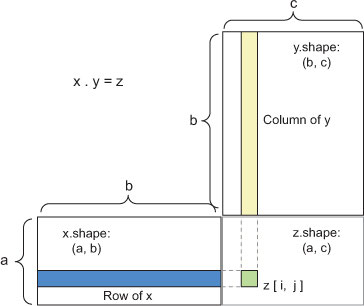

#### Cambiar la forma de tensores
- Esto es muy importante, porque lo vamos a usar mucho. No le hemos usado en las capas `Dense` de nuestro ejemplo, pero si al **procesar los datos de dígitos** antes de introducirlos a nuestra red.

`train_images = train_images.reshape((60000, 28 * 28))`

- Cambiar la forma de un tensor es reorganizar sus filas y columnas para que se ajusten a una nueva forma. El tensor resultado tiene el mísmo número de coeficientes que el original:

In [17]:
x = np.array([[0., 1.],
             [2., 3.],
             [4., 5.]])
x, x.shape

(array([[0., 1.],
        [2., 3.],
        [4., 5.]]),
 (3, 2))

In [18]:
x = x.reshape((6, 1))
x, x.shape

(array([[0.],
        [1.],
        [2.],
        [3.],
        [4.],
        [5.]]),
 (6, 1))

In [19]:
x = x.reshape((2, 3))
x, x.shape

(array([[0., 1., 2.],
        [3., 4., 5.]]),
 (2, 3))

In [20]:
# Caso especial de cambio de forma es la Transposición
# Que, como bien sabéis, es cambiar filas por columnas
# con lo que x[i,:] se convierte en x[:,i]
x = np.zeros((300, 20))
y = np.transpose(x)
x.shape, y.shape

((300, 20), (20, 300))

#### Interpretación Geométrica de las Operaciones con Tensores
Le damos una interpretación geométrica basándonos en que los tensores son coordenadas de puntos en un espacio.
- Por ejemplo, para el vector ``A[0.5, 1]``

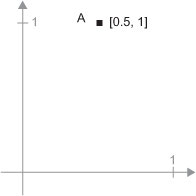

- El vector suele representarse con una flecha desde el origen:

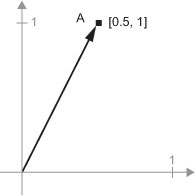

- Consideramos ahora el vector `B=[1, 0.25]` y lo sumamos en suma vectorial tradicional

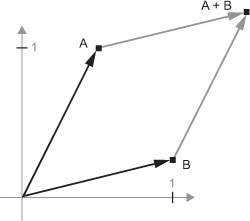

- Las operaciones geométricas elementales, como las transformaciones afines, las rotaciones, escaladas, etc, se pueden expresar como operaciones con tensores. Ejemplo: **Rotación** de un vector 2D en un ángulo **theta** a través de un **producto escalar** con una matriz de 2 x 2 `R=[u, v]`, donde `u` y `v` son dos vectores del plano: `u = [cos(theta), sin(theta)]` y `v = [-sin(theta), cos(theta)]`

#### Interpretación Geométrica del Deep Learning

Repasando:
- Las RNA consisten en:
  - Cadenas de **operaciones de tensores**
  - Esas operaciones son solo **transformaciones geométricas** de los **datos de entrada**

Solo que son **transformaciones geométricas muy complejas** en un espacio **muy dimensional**, implementada a través de **largas series** de **pasos simples**

Imaginarlo con el ejemplo de las dos hojas de papel de colores azul y roja, una encima de la otra, y arrugadas juntas en una bolita.
- La bola arrugada son nuestros datos de entrada
- Cada hoja es una clase de datos en nuestro problema de clasificación
- La red neuronal, en este caso, u otro algoritmo de machine learning, idea una transformación para que la bola deje de estar arrugada y las dos hojas puedan separarse limpiamente.
  - Con DL seria una serie de transformaciones simples del espacio 3D (lo que hacemos con los dedos, con un movimiento cada vez)


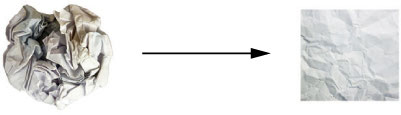

---